<a href="https://colab.research.google.com/github/JovitorzZ/CP1--2Sem-Front-end/blob/main/CP1_Front_End_%26_Mobile_Development_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes + Objetivo:
---
* João Vitor Pires da Silva - RM: 556213
* Tiago Toshio Kumagai Gibo - RM: 556984
* Israel Dalcin Alves Diniz - RM: 554668
* Pablo Menezes Barreto - RM: 556389
* Matheus Hungaro Fidelis - RM: 555677
* Danilo Ramalho Silva - RM: 555183

---
## Objetivo (Notebook 1):
* Aprimorar o código de web scrapping para obter os dados dos 250 filmes disponíveis no link: https://www.imdb.com/chart/top/?ref_=nv_mv_250 . (Codigo disponibilizado na aula de 20250822)

* Repetir o treinamento do modelo KMeans com k=5, utilizando a base de dados melhorada pelo tópico anterior.

* Repetir as análises dos clusters conforme apresentado no notebook da aula (não esqueçam dos comentários/insights das análises no final do notebook)


## Imports

In [1]:
import pandas as pd
import nltk
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import re
import json
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Criando nosso DF

1. Nosso DF irá conter filmes que estavam no top 250 nos anos 2025 e 2024.
2. Iremos utilizar Web-Scarping para conseguir os dados de 2025, já os
dados de 2024 foram disponibilizados previamente pelo professor.

### Web-Scarping

In [2]:
#url = "https://www.imdb.com/chart/top/" #URL em Inglês
url = "https://www.imdb.com/pt/chart/top/?ref_=nv_mv_250" #URL em Português
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)

# Extrair JSON do script
match = re.search(r'<script id="__NEXT_DATA__" type="application/json">(.+?)</script>', response.text)
data = json.loads(match.group(1))

movies = data["props"]["pageProps"]["pageData"]["chartTitles"]["edges"]

# Montar lista de dicionários
rows = []
for m in movies:
    node = m["node"]

    title = node["titleText"]["text"]
    year = node["releaseYear"]["year"] if node.get("releaseYear") else None
    rating = node["ratingsSummary"]["aggregateRating"]
    genres = ", ".join([g["genre"]["text"] for g in node["titleGenres"]["genres"]]) if node.get("titleGenres") else None
    synopsis = node["plot"]["plotText"]["plainText"] if node.get("plot") and node["plot"].get("plotText") else None

    rows.append({
        "Title": title,
        "Year": year,
        "Rating": rating,
        "Genres": genres,
        "Synopsis": synopsis
    })

# Criar DataFrame
df_2025 = pd.DataFrame(rows)

#print(df_2025.head(10))  # mostra os 10 primeiros

# Se quiser salvar em Excel ou CSV
# df_2025.to_csv("imdb_top250.csv", index=False)
# df_2025.to_excel("imdb_top250.xlsx", index=False)


### Trazendo os dados de 2024

In [3]:
df_2024 = pd.read_csv(r'/content/all_movies.csv', sep = ';')

### Comparando os 2 DFs

In [4]:
df_2025.head(5)

Title  Year  Rating                 Genres  \
0           Um Sonho de Liberdade  1994     9.3                  Drama   
1               O Poderoso Chefão  1972     9.2        Policial, Drama   
2  Batman: O Cavaleiro das Trevas  2008     9.1  Ação, Policial, Drama   
3     O Poderoso Chefão: Parte II  1974     9.0        Policial, Drama   
4        12 Homens e uma Sentença  1957     9.0        Policial, Drama   

                                            Synopsis  
0  Dois homens presos se reúnem ao longo de vário...  
1  O patriarca idoso de uma dinastia do crime org...  
2  Agora com a ajuda do tenente Jim Gordon e do p...  
3  O início da vida e da carreira de Vito Corleon...  
4  O julgamento de um assassinato em Nova Iorque ...

In [5]:
df_2024.head(5)

title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  
0  Aventura  Viver na Terra da Barbie é ser um ser perfeito...  
1     Drama  Dois homens presos se reúnem ao longo de vário...  
2  Policial  O patriarca idoso de uma dinastia do crime org...  
3      Ação  Quando a ameaça conhecida como O Coringa surge...  
4  Policial  Em 1950, Michael Corleone, agora à frente da f...

### Modelando nosso DF

In [6]:
#Ajustando o nome das colunas de 2024 para o padrão de 2025
dic_coluna = {'title_pt': 'Title',
              'year': 'Year',
              'rating':'Rating',
              'genre':'Genres',
              'sinopse':'Synopsis'}

df_2024.rename(columns=dic_coluna, inplace=True)

#Removendo a coluna [title_en], já que optamos por seguir somente com o idioma português como padrão
df_2024 = df_2024.drop(columns=['title_en'], axis=0)

#Concatenando os DFs
df = pd.concat([df_2024, df_2025])

#Removendo linhas duplicadas do nosso DF
df = df.drop_duplicates().reset_index(drop=True)

# Mantendo apenas o primeiro gênero de cada filme, visto que os dados de 2024 só possuem um gênero
df['Genres'] = df['Genres'].str.split(',').str[0].str.strip()

df

Title  Year  Rating    Genres  \
0                                 Barbie  2023     7.4  Aventura   
1                  Um Sonho de Liberdade  1994     9.3     Drama   
2                      O Poderoso Chefão  1972     9.2  Policial   
3         Batman: O Cavaleiro das Trevas  2008     9.0      Ação   
4                   O Poderoso Chefão II  1974     9.0  Policial   
..                                   ...   ...     ...       ...   
481  Demon Slayer: Mugen Train - O Filme  2020     8.2  Animação   
482                 Gangues de Wasseypur  2012     8.2      Ação   
483                 Na Natureza Selvagem  2007     8.0  Aventura   
484                          A Chantagem  2015     8.2  Policial   
485                       Troca Surpresa  2023     8.3   Comédia   

                                              Synopsis  
0    Viver na Terra da Barbie é ser um ser perfeito...  
1    Dois homens presos se reúnem ao longo de vário...  
2    O patriarca idoso de uma dinastia do crime org...  
3    Quando a ameaça conhecida como O Coringa surge...  
4    Em 1950, Michael Corleone, agora à frente da f...  
..                                                 ...  
481  Tanjiro, Inosuke e Zenitsu são enviados pelo c...  
482  Um confronto entre Sultão e Shahid Khan leva à...  
483  Depois de terminar a universidade, Christopher...  
484  Um homem toma medidas desesperadas para tentar...  
485  Trocadas por acidente enquanto viajavam até a ...  

[486 rows x 5 columns]

## Análise Exploratória dos dados

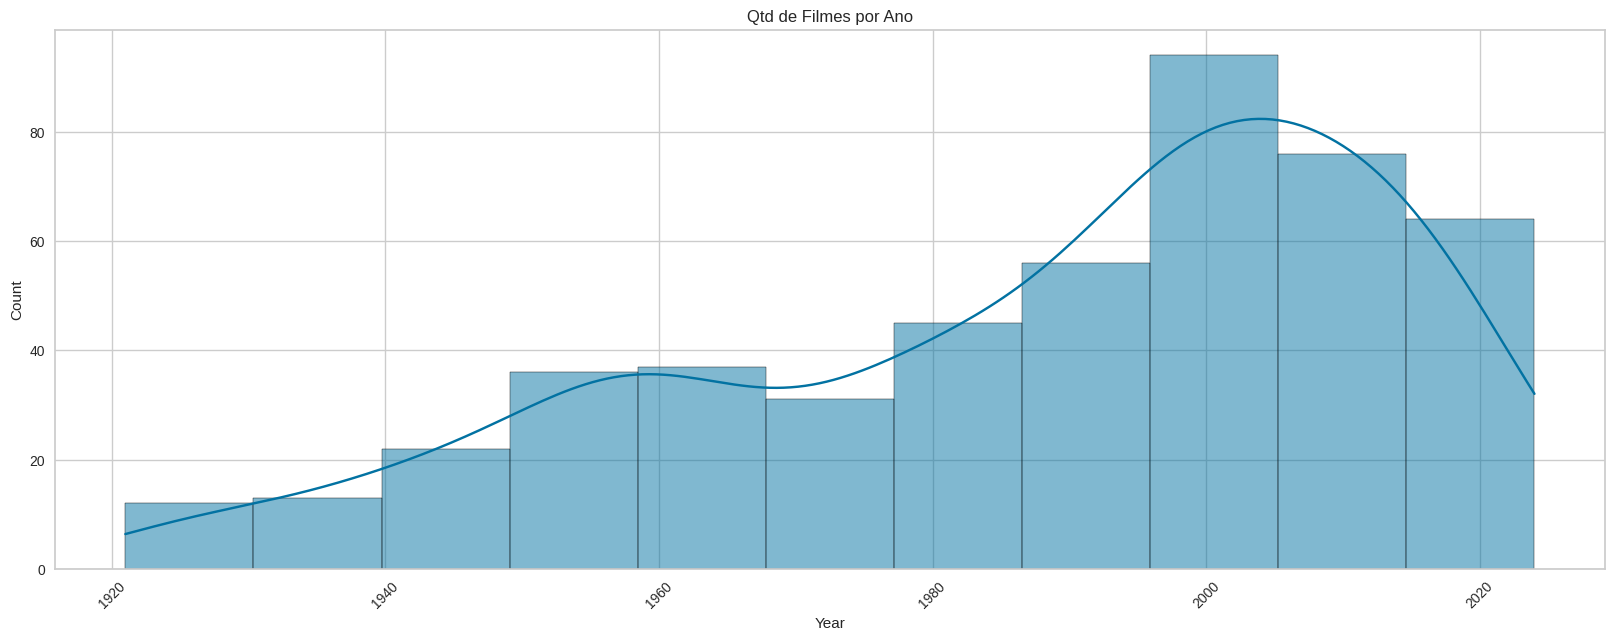

In [7]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'Year',
              kde = True).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

In [8]:
df.describe()

Year      Rating
count   486.000000  486.000000
mean   1987.615226    8.305350
std      25.486242    0.232716
min    1921.000000    7.400000
25%    1968.000000    8.100000
50%    1995.000000    8.200000
75%    2008.000000    8.400000
max    2024.000000    9.300000

In [9]:
fig = px.bar(df.Genres.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

In [10]:
df['Genres'].value_counts()

Genres
Drama         124
Ação           86
Policial       71
Animação       50
Comédia        49
Biografia      47
Aventura       44
Terror          7
Mistério        5
Faroeste        2
Filme noir      1
Name: count, dtype: int64

In [11]:
df['Genres'].value_counts(normalize=True)

Genres
Drama         0.255144
Ação          0.176955
Policial      0.146091
Animação      0.102881
Comédia       0.100823
Biografia     0.096708
Aventura      0.090535
Terror        0.014403
Mistério      0.010288
Faroeste      0.004115
Filme noir    0.002058
Name: proportion, dtype: float64

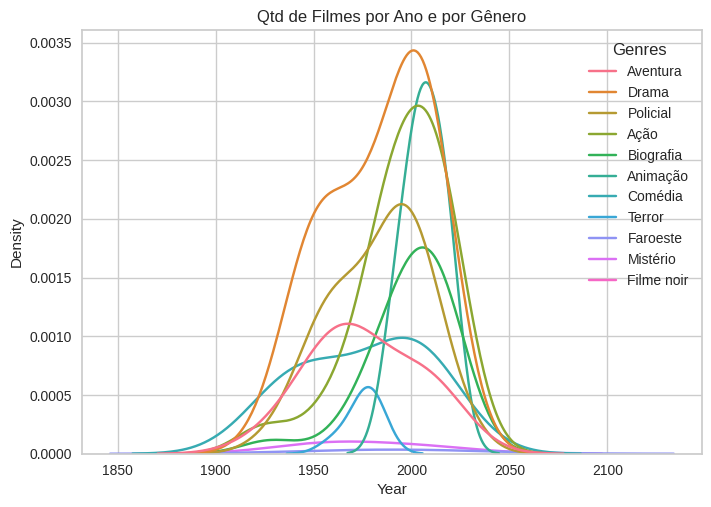

In [12]:
sns.kdeplot( df, x = 'Year', hue = 'Genres', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

#### Insights:
* Temos uma Grande concentração de filmes após os anos 90 com uma queda bem próxima a 2010, ano que tem um marco na industria de Filmes/Cinema com o lançamento da Netflix e inicio da popularização das plataformas de Streaming

* Os Gêneros com maior predominancia são: Drama (25%), Ação (17%) e Policial (14%).

## Pré-processamento de texto

In [13]:
#Convertendo as sinopses para minúsculas
df_processed = df.copy()
df_processed['Synopsis'] = df_processed['Synopsis'].str.lower()
df_processed['Synopsis'].head()

0    viver na terra da barbie é ser um ser perfeito...
1    dois homens presos se reúnem ao longo de vário...
2    o patriarca idoso de uma dinastia do crime org...
3    quando a ameaça conhecida como o coringa surge...
4    em 1950, michael corleone, agora à frente da f...
Name: Synopsis, dtype: object

In [14]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [15]:
df_processed['word_count'] = df_processed['Synopsis'].apply(qty_words).astype('int64')
df_processed.head()

Title  Year  Rating    Genres  \
0                          Barbie  2023     7.4  Aventura   
1           Um Sonho de Liberdade  1994     9.3     Drama   
2               O Poderoso Chefão  1972     9.2  Policial   
3  Batman: O Cavaleiro das Trevas  2008     9.0      Ação   
4            O Poderoso Chefão II  1974     9.0  Policial   

                                            Synopsis  word_count  
0  viver na terra da barbie é ser um ser perfeito...          29  
1  dois homens presos se reúnem ao longo de vário...          21  
2  o patriarca idoso de uma dinastia do crime org...          20  
3  quando a ameaça conhecida como o coringa surge...          33  
4  em 1950, michael corleone, agora à frente da f...          41

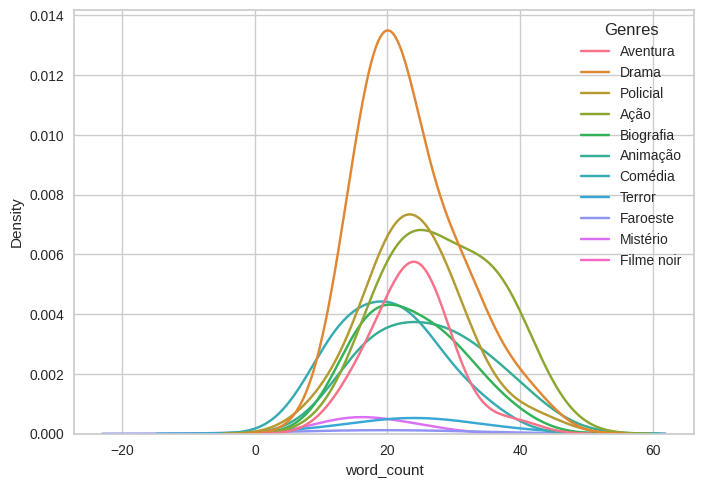

In [16]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'Genres', bw_adjust = 1.5, warn_singular = False)
plt.show()

### Observações:
* Maior parte dos filmes de Policiais e de Drama possuem em média 20 palvras para descrevê-los

## Nuvem de palavras

### Antes de remover stopwords

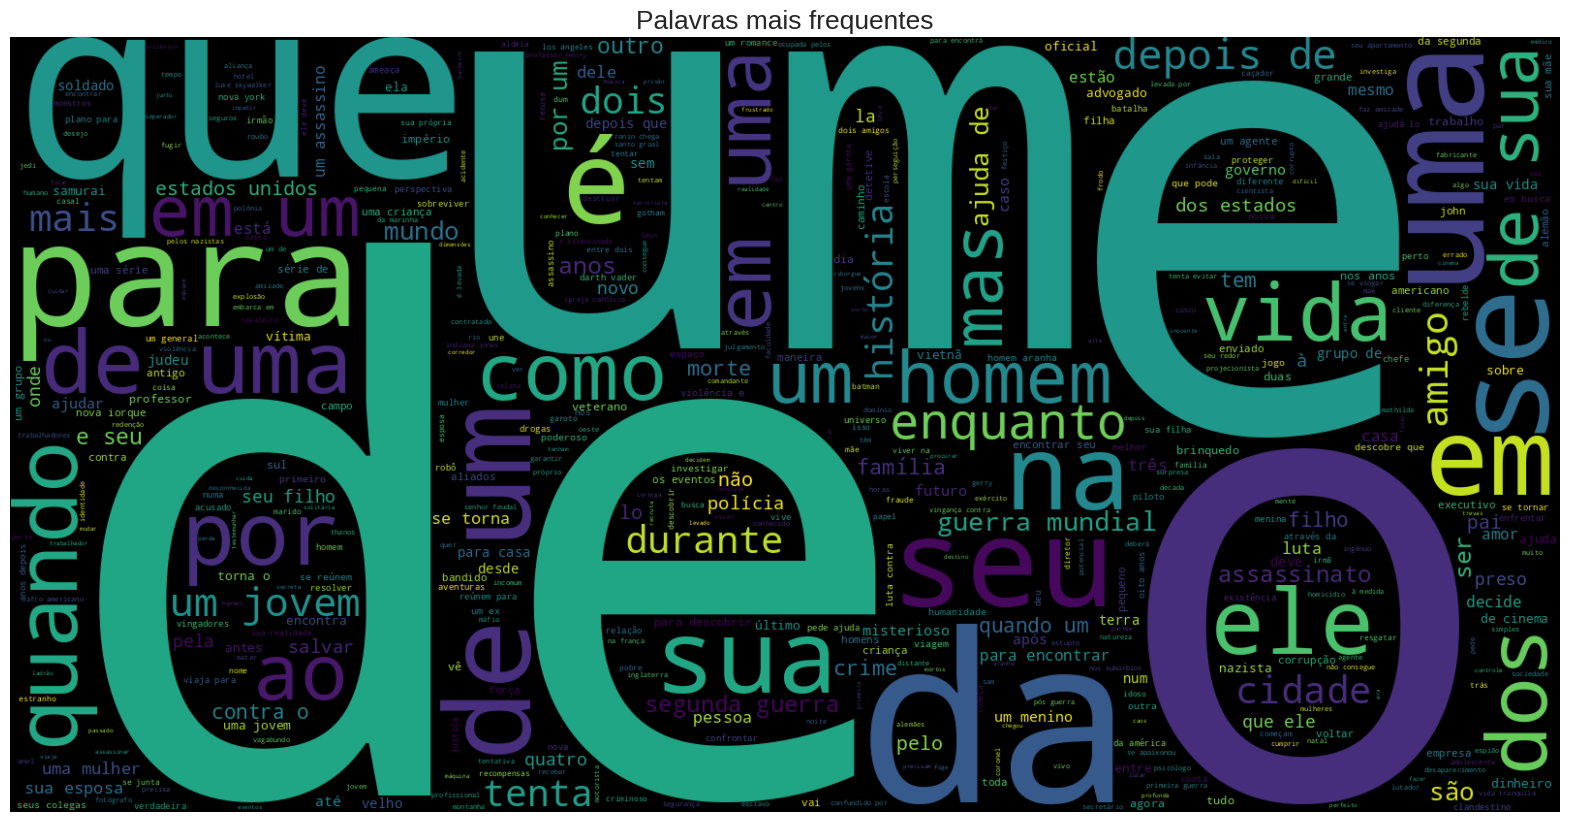

In [17]:
text = ' '.join([phrase for phrase in df_processed['Synopsis']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [18]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


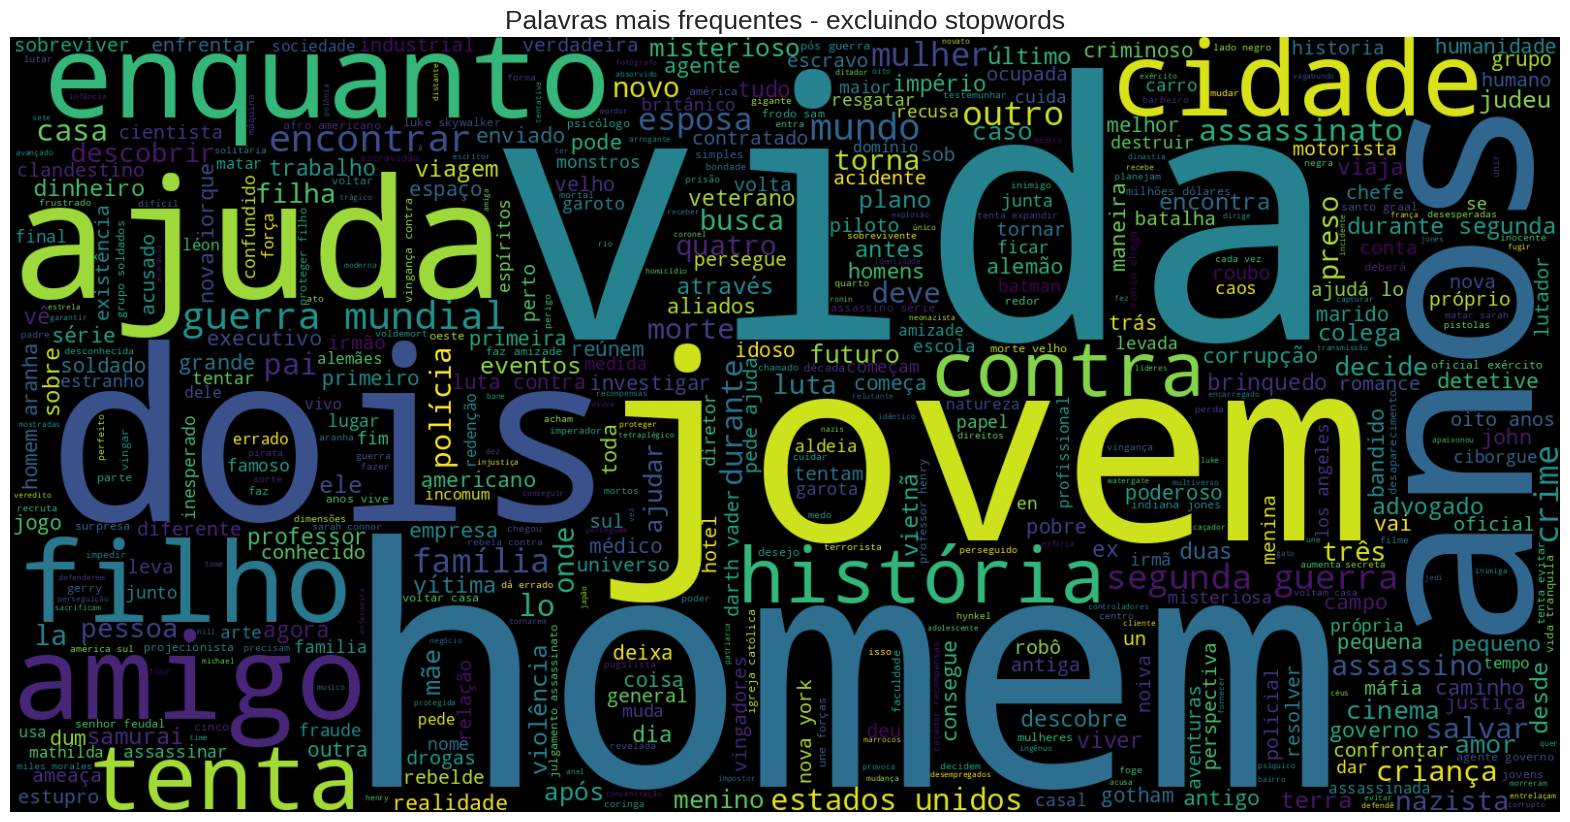

In [19]:
df_processed['sinopse_no_stopwords'] = df_processed['Synopsis'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF

In [35]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [36]:
print(X.shape)
X.toarray()

(486, 15)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.69424093, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## KMeans - Clusterização

### Escolhendo o numero de "k" clusters ideal

### Método Elbow

In [22]:
df_processed

Title  Year  Rating    Genres  \
0                                 Barbie  2023     7.4  Aventura   
1                  Um Sonho de Liberdade  1994     9.3     Drama   
2                      O Poderoso Chefão  1972     9.2  Policial   
3         Batman: O Cavaleiro das Trevas  2008     9.0      Ação   
4                   O Poderoso Chefão II  1974     9.0  Policial   
..                                   ...   ...     ...       ...   
481  Demon Slayer: Mugen Train - O Filme  2020     8.2  Animação   
482                 Gangues de Wasseypur  2012     8.2      Ação   
483                 Na Natureza Selvagem  2007     8.0  Aventura   
484                          A Chantagem  2015     8.2  Policial   
485                       Troca Surpresa  2023     8.3   Comédia   

                                              Synopsis  word_count  \
0    viver na terra da barbie é ser um ser perfeito...          29   
1    dois homens presos se reúnem ao longo de vário...          21   
2    o patriarca idoso de uma dinastia do crime org...          20   
3    quando a ameaça conhecida como o coringa surge...          33   
4    em 1950, michael corleone, agora à frente da f...          41   
..                                                 ...         ...   
481  tanjiro, inosuke e zenitsu são enviados pelo c...          37   
482  um confronto entre sultão e shahid khan leva à...          25   
483  depois de terminar a universidade, christopher...          20   
484  um homem toma medidas desesperadas para tentar...          22   
485  trocadas por acidente enquanto viajavam até a ...          17   

                                  sinopse_no_stopwords  
0    viver terra barbie perfeito lugar perfeito. me...  
1    dois homens presos reúnem longo vários anos, e...  
2    patriarca idoso dinastia crime organizado tran...  
3    ameaça conhecida coringa surge passado, causa ...  
4    1950, michael corleone, agora frente família, ...  
..                                                 ...  
481  tanjiro, inosuke zenitsu enviados comando esqu...  
482  confronto sultão shahid khan leva expulsão kha...  
483  terminar universidade, christopher mccandless ...  
484  homem toma medidas desesperadas tentar salvar ...  
485  trocadas acidente enquanto viajavam casa novos...  

[486 rows x 7 columns]

2 260.0654958329519
3 240.10724715679487
4 213.52685165663647
5 202.63425042943746
6 176.38477450262403
7 157.7998467342226
8 143.34975899470243
9 127.8521964453926
10 99.88080103911766
11 94.01747448474781


Text(0, 0.5, 'WCSS')

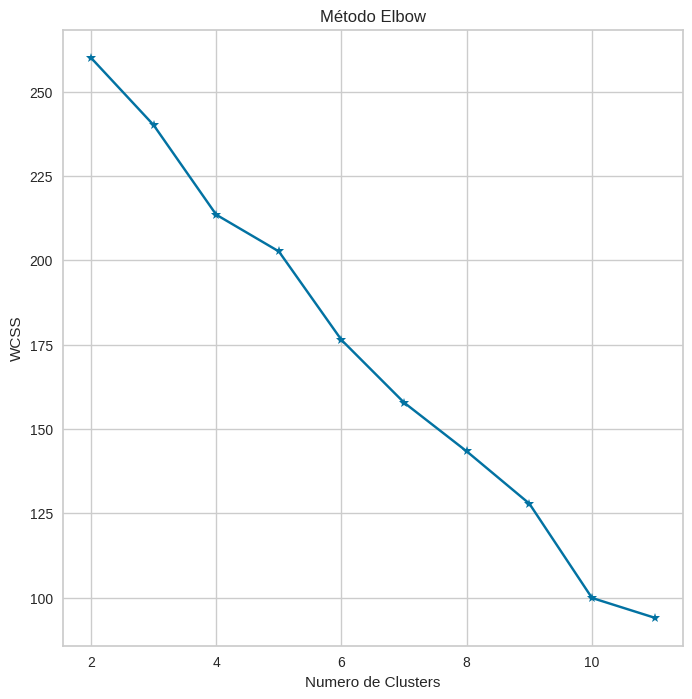

In [39]:
plt.figure(figsize = (8,8))

#plotando o grafico do método elbow
wcss = []

for i in range(2, df_processed.Genres.nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df_processed.Genres.nunique()+1), wcss, '*-')
plt.title('Método Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS') #within cluster sum of square

### Método Silhouette

In [24]:
df_processed.Genres.nunique()

11

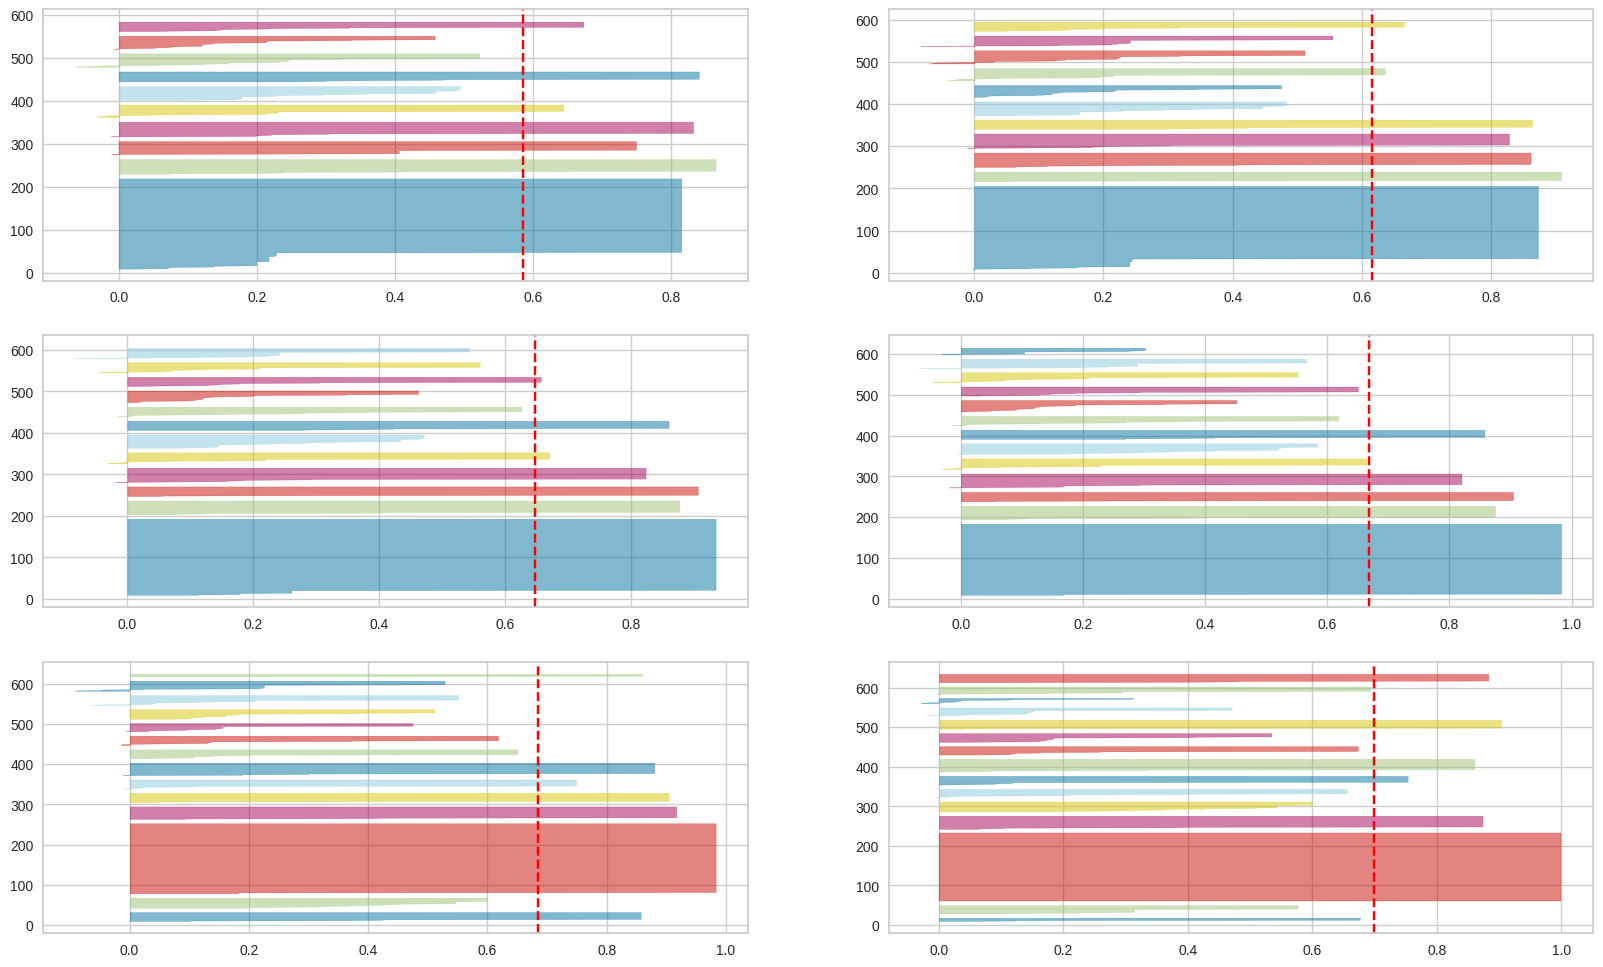

In [25]:
# fig, ax = plt.subplots(3,2, figsize = (20,12))
# for i in (range(10, 17)):
#   #Creating KMeans instance for different number of clusters
#   kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
#   q, mod = divmod(i,2)

#   #Creating SilhouetteVisualizer instance with KMeans instance
#   #Fit the visualizer

#   visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
#   visualizer.fit(X)

fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = i + 10, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

### Análise do número de clusters

* O método de elbow indicou um numero de k ideal entre 9 e 11. Pelo método de Silhouete não ficou muito claro. Para efeitos didáticos, será adotado k=5 para facilitar as análises, mas em um projeto real deve ser testado o numero de k indicado pelos 2 métodos.

# Comparativo entre os 5 clusters

In [26]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans = kmeans.fit(X)
#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)
#getting the cluster centers
c = kmeans.cluster_centers_

df_processed['cluster'] = labels
df_processed.head()

Title  Year  Rating    Genres  \
0                          Barbie  2023     7.4  Aventura   
1           Um Sonho de Liberdade  1994     9.3     Drama   
2               O Poderoso Chefão  1972     9.2  Policial   
3  Batman: O Cavaleiro das Trevas  2008     9.0      Ação   
4            O Poderoso Chefão II  1974     9.0  Policial   

                                            Synopsis  word_count  \
0  viver na terra da barbie é ser um ser perfeito...          29   
1  dois homens presos se reúnem ao longo de vário...          21   
2  o patriarca idoso de uma dinastia do crime org...          20   
3  quando a ameaça conhecida como o coringa surge...          33   
4  em 1950, michael corleone, agora à frente da f...          41   

                                sinopse_no_stopwords  cluster  
0  viver terra barbie perfeito lugar perfeito. me...        0  
1  dois homens presos reúnem longo vários anos, e...        4  
2  patriarca idoso dinastia crime organizado tran...        0  
3  ameaça conhecida coringa surge passado, causa ...        0  
4  1950, michael corleone, agora frente família, ...        0

# Filmes por cluster

In [27]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

# % de Gêneros por Cluster

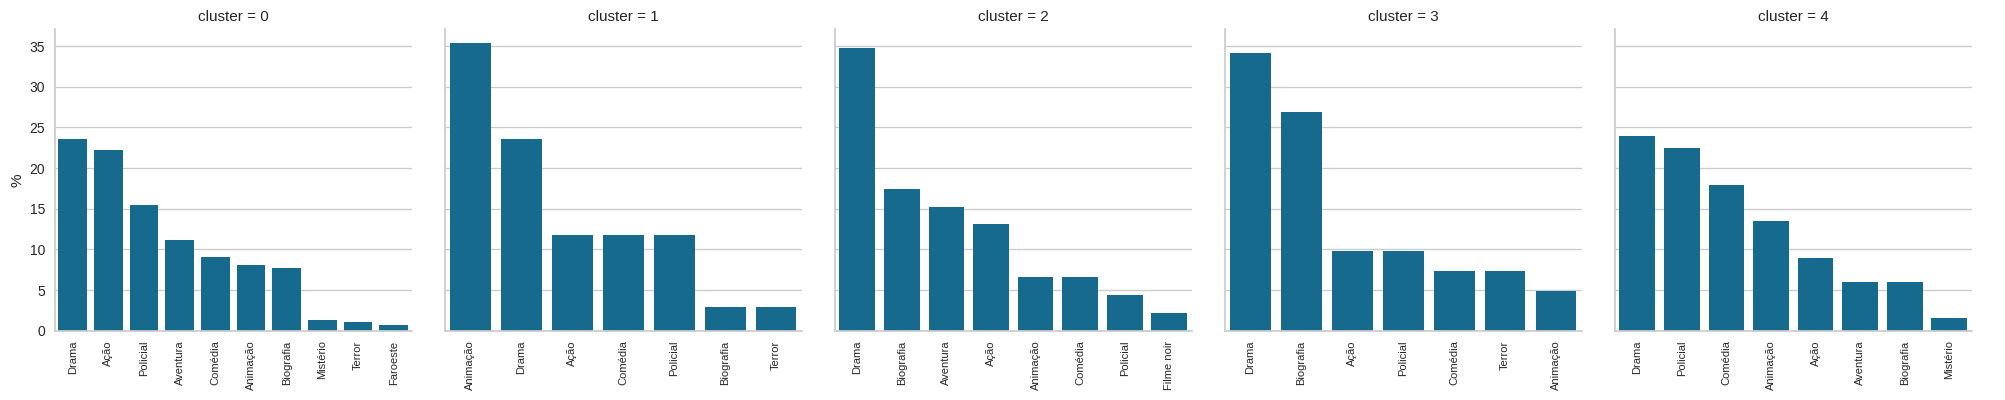

In [28]:
df_plot = df_processed.groupby(['cluster', 'Genres'])['Title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'Title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="Genres", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

# Ano de Lançamento por Cluster

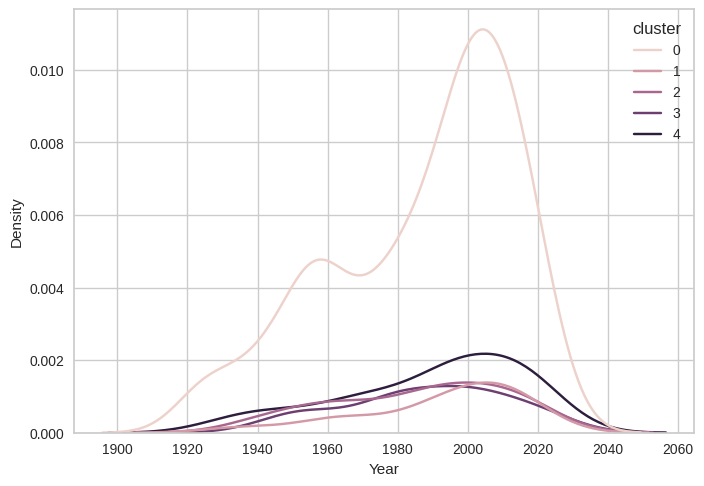

In [29]:
sns.kdeplot(df_processed, x = 'Year', hue = 'cluster');

# Radar | Gêneros por Cluster

In [30]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'Genres', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster      Genres          0          1          2          3          4
0          Animação   8.053691  35.294118   6.521739   4.878049  13.432836
1          Aventura  11.073826   0.000000  15.217391   0.000000   5.970149
2              Ação  22.147651  11.764706  13.043478   9.756098   8.955224
3         Biografia   7.718121   2.941176  17.391304  26.829268   5.970149
4           Comédia   9.060403  11.764706   6.521739   7.317073  17.910448
5             Drama  23.489933  23.529412  34.782609  34.146341  23.880597
6          Faroeste   0.671141   0.000000   0.000000   0.000000   0.000000
7        Filme noir   0.000000   0.000000   2.173913   0.000000   0.000000
8          Mistério   1.342282   0.000000   0.000000   0.000000   1.492537
9          Policial  15.436242  11.764706   4.347826   9.756098  22.388060
10           Terror   1.006711   2.941176   0.000000   7.317073   0.000000

In [31]:
df_polar = df_pivot.melt(id_vars=['Genres'])
df_polar.head()

Genres cluster      value
0   Animação       0   8.053691
1   Aventura       0  11.073826
2       Ação       0  22.147651
3  Biografia       0   7.718121
4    Comédia       0   9.060403

In [32]:
fig = px.line_polar(df_polar, r='value', theta='Genres', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

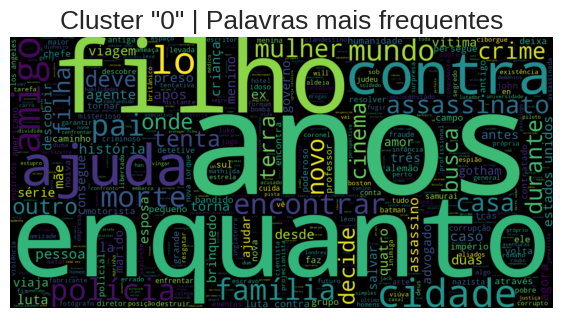

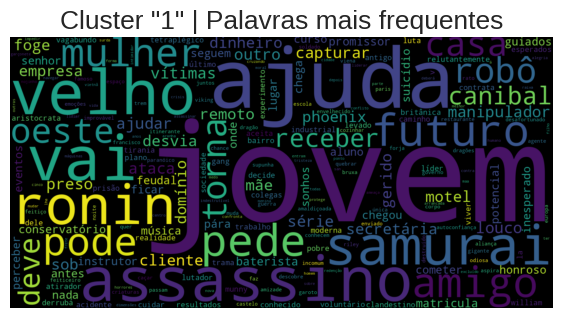

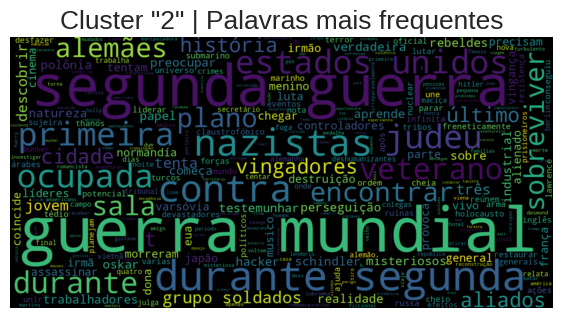

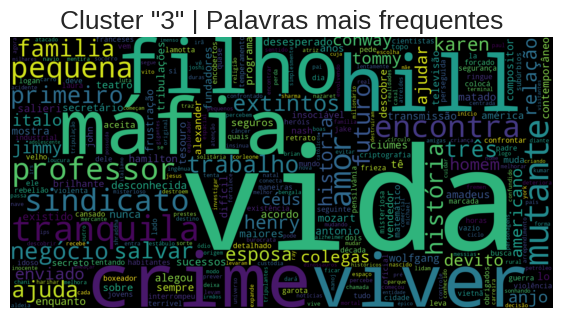

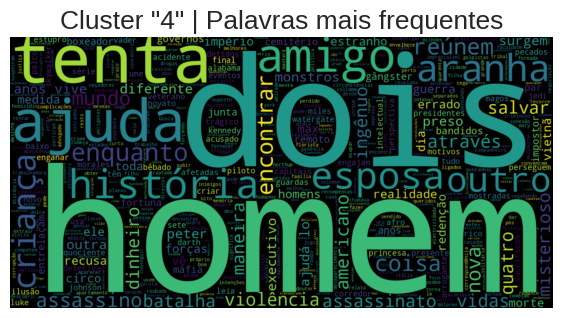

In [33]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# Considerações finais

Primeiro, observamos a distribuição de filmes por cluster. O cluster 0 apresentou o maior número de amostras (filmes).

Em seguida, analisamos a porcentagem de cada gênero por cluster para identificar os gêneros mais representativos em cada um:

* Cluster 0: Drama, Ação e Policial
* Cluster 1: Animação, Drama, Ação e Comédia/Policial
* Cluster 2: Drama, Biografia e Aventura
* Cluster 3: Drama e Biografia
* Cluster 4: Policial, Drama e Comédia

Na sequência, avaliamos a distribuição dos anos de lançamento dos filmes por cluster. O cluster 0 concentra a maioria dos filmes, com pico próximo ao ano 2000, e os demais clusters mostram uma distribuição mais dispersa ao longo dos anos, mas também com alguma concentração em períodos mais recentes.

Depois, apresentamos um gráfico de radar por cluster, que visualiza a representatividade de cada gênero em cada cluster, corroborando a análise de porcentagem de gêneros.

Finalmente, as nuvens de palavras por cluster destacam os temas predominantes em cada grupo:

* Cluster 0: Palavras como "homem", "anos", "vida", "polícia", "ajuda", sugerindo temas de drama, ação e policial com foco em personagens e situações de conflito.

* Cluster 1: Palavras como "jovem", "casa", "futuro", "ajuda", "assassino", indicando histórias com personagens jovens, talvez com elementos de mistério ou suspense.

* Cluster 2: Palavras como "guerra mundial", "segunda guerra", "estados unidos", "alemães", "judeu", apontando para filmes com temáticas históricas e de guerra.

* Cluster 3: Palavras como "vida", "filho", "homem", "trabalho", "história", sugerindo dramas focados em relações pessoais e jornadas individuais.

* Cluster 4: Palavras como "homem", "dois", "outro", "ajuda", "história", "policial", indicando narrativas com foco em duplas de personagens ou confrontos, frequentemente em contextos policiais.

In [34]:
df_processed.to_csv("CP1.csv", index=False)